# V2 PPM

Tier 1,
- 😭 Drawing Circles around the Shrub locations (Done, to be revisited in V3)
- ✅ Adding variables for the following aspect (Done, some variables, like controlling RL output have not been done)
    - ✅ Seed control for grid generation (Done)
    - 🛑 Seed Control for RL generation 
    - ✅ Proportion of seeds that are going to be used (Done)
- ✅ Experiment with Grid detection in order ot find out where to mirror for maniqured

Tier 2
- ✅ Adding an influence fromn the contour lines based on the shape of the region in conjuction to the noise, in the ratio of alpha + beta (new variables)
- ✅ Experiment with different tpyes of noise (Record the difference in results when using perlin, Worley, anymore etc.)
- ✅ Include jitter to move shrub locations that can be toggled for the sake of naturalistic planting
    - Randomly (v2 model)

Tier 3 
- Improve the algo for the jittering used in naturalistic planting
    - Algo to move it to less conjested areas 
- ✅ Do a cleaning algoriithm to remove pimples on the map
- ✅ Redo the relabelling function
- Figure out key allpha and beta balance values and seed proportions that can be used for naturalistic and maniqured (I suspect a higher beta and higher proportion of seeds would be beneficical for naturalistic, while a higher alpha and lower seed proportion would be similar to maniqured)
- ✅ Cleanup functin
- incorporate styyles and theming
- RL model to choose the plants for the areas :DDDDDDDD

(Stretch goals )
- Trying to change the shape of the regions according to the direction of the

## Glossary

- Styles: How the area looks (naturalistic or maniqured)
- Themeing: What the context of the area is

# Properly Compiled
Only properly tested things
DO NOT EXPERIMENT HERE

---

### Imports

Imports are below so that the function name can be shown when hidden

In [17]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import random
from perlin_noise import PerlinNoise
from scipy.spatial.distance import cdist
import cv2
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import os
import copy
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import label
from scipy.stats import mode


### Grid generation base class

Base class function that is used to generate shrub and tree placement

Meant to be repolaced with WX version in the future

In [18]:
class customSpatialEnv(gym.Env):
    def __init__(self, octave: float, grid_size: tuple = (100, 100), seed: int = None):
            """
            Args:
                octave (float): octave value from range [1-2] for Perlin noise.
                grid_size (tuple): (width, height) of the grid, defaults to (100, 100).
                seed (int): Random seed for reproducibility, defaults to None.
            """
            super(customSpatialEnv, self).__init__()
            self.seed_value = seed
            self.random_state = np.random.RandomState(seed)  # Controlled randomness
            self.grid_size = grid_size
            self.octave = octave
            self.max_attempts = 100000  # Maximum number of attempts
            self.attempt_counter = 0  # Tracks the number of attempts

            self.grid, self.planting_coordinates, self.distances = self._create_environment()

            # Plants: 1 for Tree, 2 for Shrub, 0 for No plant (added)
            self.plants = np.array([0, 1, 2])  # [No Plant, Tree, Shrub]

            # Action space: Use Box for percentage (horizontal, vertical) and plant type (no object, shrub, tree)
            self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

            # Observation space: Dict containing the grid and distances (both horizontal and vertical)
            self.observation_space = spaces.Dict({
                "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
                "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Vertical distance (top)
                "tree_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of trees
                "shrub_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of shrubs
                "good_tree_spot": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Whether the spot is good for planting a tree
                "border_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  
            })

            self.num_trees = 0
            self.num_shrubs = 0
            self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        tree_proportion = np.array([0.0], dtype=np.float32)
        shrub_proportion = np.array([0.0], dtype=np.float32)
        good_tree_spot = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)
        border_score = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)

        # Initial observation
        return {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1), now including No Plant.
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = 0  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.33:
            plant_type = 0  # No Plant (new option)
        elif plant_type_selector < 0.66:
            plant_type = 1  # Tree
        else:
            plant_type = 2  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            if len(self.distances) > 0:  # Ensure there are distances to access
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            ####################################################################################
            ### Shrub Proportion and Tree proportion and reward mechanism
            #  Calculate tree and shrub proportions
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0
            balance_reward = 0

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions
                if tree_proportion > 0.2:
                    balance_reward += 2

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1
                if shrub_proportion > 0.6:
                    balance_reward += 1

            ####################################################################################
            ### Good Tree Spot and Distance mechanism
            good_tree_spot = 1.0  # Assume the spot is good initially
            if plant_type == 1:  # Only check for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):
                        continue
                    # Calculate the distance between the planted tree and all other trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # If any tree is within 50 units, it's not a good spot
                        good_tree_spot = 0.0
                        break
            distance_reward = 0.5
            # Only apply reward for trees (plant_type == 1)
            if self.plants[plant_type] == 1:
                # Apply a reward based on how far the nearest tree is, capped at 50 units
                if good_tree_spot == 1.0:
                    distance_reward = 1  # Normalize reward (closer to 50 = higher reward)
                else:
                    distance_reward = 0

            ####################################################################################

            ### Border Score Segment

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            border_score = 0
            if (abs(horizontal_distance - 0.5) + abs(vertical_distance - 0.5)) > 0.8:
                border_score = 1

            ####################################################################################

            ### Total reward Segment
            reward = 3 * balance_reward + 2 *distance_reward + border_score
            ####################################################################################

            if plant_type == 0:
            # No planting is done, but a small positive reward could be given to avoid excessive no-action use
                reward = 1

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action
            tree_proportion = self.num_trees / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            shrub_proportion = self.num_shrubs / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            good_tree_spot = 0.0

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)
        tree_proportion = np.array([tree_proportion], dtype=np.float32)
        shrub_proportion = np.array([shrub_proportion], dtype=np.float32)
        good_tree_spot = np.array([good_tree_spot], dtype=np.float32)
        border_score = np.array([border_score], dtype=np.float32)

        # Observation: the current state of the environment (grid, distances, and tree/shrub proportions)
        observation = {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment using Perlin noise.
        """
        while True:
            # Use the random state for reproducibility
            seed = self.random_state.randint(0, 50) if self.seed_value is None else self.seed_value
            noise = PerlinNoise(octaves=self.octave, seed=seed)
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i / height, j / width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5 / 100:
                break

        planting_grid, planting_coords = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env)  # Adjust input as needed
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy

    
    
import matplotlib.patches as mpatches
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=100000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        # print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model

def load_pretrained_model(model_path):
    """
    Load a pretrained PPO model from a specified path.
    """
    if not os.path.exists(model_path):
        raise ValueError(f"Model path {model_path} does not exist.")
    
    model = PPO.load(model_path)
    print(f"Loaded model from {model_path}")
    return model


def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.
    """
    obs, _ = env.reset()
    step = 0

    while True:
        action, _states = model.predict(obs, deterministic=False)
        noise = np.random.normal(0, 0.05, size=action.shape)
        randomized_action = np.clip(action + noise, 0, 1)
        obs, reward, terminated, truncated, info = env.step(randomized_action)
        
        step += 1

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return env.grid  # Only return the grid


def extract_tree_shrub_placements(grid):
    """
    Extracts the tree and shrub placements from the final grid.
    
    Args:
        grid (np.ndarray): The final grid after placement.
    
    Returns:
        trees (list of tuple): List of coordinates of tree placements.
        shrubs (list of tuple): List of coordinates of shrub placements.
    """
    trees = list(zip(*np.where(grid == 1)))
    shrubs = list(zip(*np.where(grid == 2)))
    return trees, shrubs


# Main function to load model and generate new placement
def createGrid(model_path, seed=None):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.

    Args:
        model_path (str): Path to the pretrained model.
        seed (int, optional): Random seed for reproducibility. Defaults to None.

    Returns:
        np.ndarray: Final grid with plant placements.
    """
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100), seed=seed)
    model = load_pretrained_model(model_path)
    final_grid = generate_new_placement(env, model)
    return final_grid


# Visualization (optional, for debugging)
def visualize_grid_with_circles(grid):
    plt.figure(figsize=(8, 8))
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},
        1: {'color': 'green', 'label': 'Tree', 'size': 50},
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},
        255: {'color': 'black', 'label': 'Border', 'size': 20},
    }

    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=style['size'], alpha=0.8)

    plt.gca().invert_yaxis()
    plt.legend(title="Legend", loc='upper right')
    plt.title("Grid Visualization")
    plt.grid(False)
    plt.show()

## Helper Functions 
These functions area used to generate other stuff in the bigger functions

---

### Shade_inside_border
Helper function to create the regions that are plantable areas and those that are not

Inputs:
- grid: 100 by 100 numpy array
- border-value: int that is used to represent the border on the grid
- fill_value: value to be used to fill the plantable spots

In [19]:
def shade_inside_border(grid, border_value=255, fill_value=128):
    """
    Shade points inside the black borders on the grid with a specified fill color,
    leaving outside regions untouched.

    Args:
        grid (np.ndarray): The grid representing the environment.
        border_value (int): Value representing the border in the grid.
        fill_value (int): Value to fill the inside regions with.

    Returns:
        np.ndarray: Modified grid with inside regions shaded with the fill color.
    """
    # Create a mask for border areas
    border_mask = grid == border_value

    # Use binary_fill_holes to fill regions inside the border
    filled_region = binary_fill_holes(border_mask)

    # Create a copy of the grid to modify
    shaded_grid = np.copy(grid)
    
    # Apply the fill color to inside regions only
    shaded_grid[filled_region] = fill_value
    # plt.imshow(shaded_grid, cmap="gray")
    # plt.title("Grid with Inside Regions Shaded")
    # plt.show()
    
    return shaded_grid

def visualize_grid_with_types(grid, type_labels=None):
    """
    Visualize a grid with different types (e.g., Open Canopy, Intermediate Canopy) using a unique color for each type.

    Args:
        grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
        type_labels (dict): Optional dictionary mapping grid values to labels, e.g., {0: "Empty", 1: "Shrub", 3: "Starter Type 1"}.
    """
    # Define a colormap for visualization
    unique_values = np.unique(grid)
    colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors
    
    # Create a color map dictionary
    color_map = {val: colors[i] for i, val in enumerate(unique_values)}
    type_labels = type_labels or {val: f"Type {val}" for val in unique_values}

    # Create the plot
    plt.figure(figsize=(8, 8))
    for value, color in color_map.items():
        indices = np.argwhere(grid == value)
        plt.scatter(indices[:, 1], indices[:, 0], color=color, label=type_labels.get(value, f"Type {value}"), s=50, alpha=0.8)

    plt.gca().invert_yaxis()
    plt.title("Grid Visualization with Types")
    plt.legend(title="Legend", loc='upper right')
    plt.grid(False)
    plt.show()



# final_grid = createGrid(model_path)
# visualize_grid_with_types(final_grid)
# grid = shade_inside_border(final_grid)
# print(grid)

### label_near_tree function

Function used to determine the area that is shaded and those that are not.
To be improved with something that querries the information from the database.

In [20]:
def label_near_trees(grid, tree_value=1, distance_threshold=5):
    """
    Creates a new grid where points within a given distance from a tree are labeled as 1, others as 0.

    Args:
        grid (np.ndarray): The input grid.
        tree_value (int): The value representing trees in the grid.
        distance_threshold (float): The distance threshold for labeling nearby points.

    Returns:
        np.ndarray: A new grid with points near trees labeled as 1, others as 0.
    """
    # Find the positions of trees in the grid
    tree_positions = np.argwhere(grid == tree_value)
    
    # Initialize the new grid with zeros
    new_grid = np.zeros_like(grid, dtype=np.int32)
    
    # Get all grid coordinates
    all_positions = np.array([(i, j) for i in range(grid.shape[0]) for j in range(grid.shape[1])])
    
    # Calculate the distances from all points to the tree positions
    if len(tree_positions) > 0:
        distances = cdist(all_positions, tree_positions)
        min_distances = np.min(distances, axis=1)
        
        # Mark points within the distance threshold as 1
        nearby_indices = np.where(min_distances <= distance_threshold)[0]
        for index in nearby_indices:
            i, j = all_positions[index]
            new_grid[i, j] = 1
    
    return new_grid


# final_grid = createGrid(model_path)


# distance_threshold = 25
# new_grid = label_near_trees(final_grid, tree_value=1, distance_threshold=distance_threshold)

def visualize_binary_grid(grid, title="Binary Grid"):
    plt.figure(figsize=(6, 6))
    plt.imshow(grid, cmap="gray", origin="upper")
    plt.colorbar(label="Value")
    plt.title(title)
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()


# visualize_grid_with_types(final_grid)
# visualize_binary_grid(new_grid, title=f"Points within {distance_threshold} units from trees")

### Generate Influence Plant Grid

Helper function to take a heatmap and a list of tuples in order to create a heatmap for how that species affects the land

Inputs:
- height_map: 100 x 100 numpy array
- seeds: list[(y,x)] coordinates of seeds of a particular species

Output
- influence_grid: heatmap with highest value being the value of influience of the specieis on each cell

In [21]:
def generate_influence_grid_plant_type(height_map, seeds, grid_size=(100, 100), decay_rate=0.2):
    """
    Generate an influence grid based on a height map and seed positions.
    Influence decreases radially outward from the seed values.

    Args:
        height_map (np.ndarray): A 2D array of float values representing the height map (e.g., values between 10 and 50).
        seeds (list of tuple): List of (x, y) coordinates for the seed positions.
        grid_size (tuple): The size of the influence grid, defaults to (100, 100).
        decay_rate (float): Controls the rate of decay; smaller values spread influence farther. Default is 0.5.

    Returns:
        np.ndarray: A 2D array representing the influence grid with influence values.
    """
    # Initialize an empty grid
    influence_grid = np.zeros(grid_size, dtype=np.float32)
    height, width = grid_size

    # Create a mesh grid of coordinates for distance calculation
    x_indices, y_indices = np.meshgrid(np.arange(width), np.arange(height))

    for seed in seeds:
        seed_y, seed_x = seed
        # Flip the y-coordinate to match visualization
        seed_y = grid_size[0] - 1 - seed_y
        
        # Get the height map value at the seed position
        seed_value = height_map[seed_y, seed_x]  

        # Calculate the distance from the seed to all other points in the grid
        distances = np.sqrt((x_indices - seed_x) ** 2 + (y_indices - seed_y) ** 2)

        # Influence decreases radially outward using a slower decay function
        influence = np.clip(seed_value / (1 + decay_rate * distances), 0, None)

        # Add the influence of this seed to the overall grid
        influence_grid += influence

    return influence_grid

def visualize_influence_grid(influence_grid, title="Influence Grid", cmap="viridis"):
    """
    Visualize the influence grid generated by the generate_influence_grid_plant_type function.

    Args:
        influence_grid (np.ndarray): The 2D array representing the influence grid.
        title (str): Title for the visualization. Default is "Influence Grid".
        cmap (str): Colormap to use for visualization. Default is "viridis".
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(influence_grid, cmap=cmap, origin="lower")
    plt.colorbar(label="Influence Value")
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(False)
    plt.show()


# Example usage
# Assuming `height_map` and `seeds` are already defined
# influence_grid = generate_influence_grid_plant_type(heatmap, seeds[3])
# visualize_influence_grid(influence_grid, title="Influence Grid for Plant Type")

### choose_strater_slots

Inputs:
- grid: 100 x 100 numpy array representing the grid
- shrub_positions: list of the shrub positions
- distribution_seed: number used to control the random variables
- number_of_types: the total number of different shrubs to be included in an area
- percentage_of_starters: the number_of_seeds that are used as starter positions

In [22]:
def choose_starter_slots(grid, shrub_positions, number_of_types=3, percentage_of_starters=0.8):
    """
    Selects a percentage of shrub positions to be assigned as starter slots and updates the grid with new types
    in an ordered sequence.

    Args:
        grid (np.ndarray): The current grid representing the environment.
        shrub_positions (list): List of tuples representing the positions of shrubs on the grid.
        number_of_types (int): Number of distinct starter types. Default is 3.
        percentage_of_starters (float): Percentage of shrub positions to use as starter slots. Default is 0.8 (80%).

    Returns:
        tuple: Updated grid with starter slots assigned, and a dictionary of seed locations by type.
    """
    working_grid = copy.deepcopy(grid)
    shrub_slots = copy.deepcopy(shrub_positions)
    seed_locations = {t: [] for t in range(3, 3 + number_of_types)}

    # Determine the number of starters based on the percentage
    number_of_starters = int(len(shrub_slots) * percentage_of_starters)
    number_of_starters = max(1, number_of_starters)  # Ensure at least one starter is selected

    # Use an ordered sequence for assigning starter types
    types_sequence = [3 + (i % number_of_types) for i in range(number_of_starters)]

    for i, assigned_type in enumerate(types_sequence):
        if not shrub_slots:  # If no more shrub positions are left, break the loop
            break
        selected_position = shrub_slots.pop(0)  # Select the next shrub position in order
        working_grid[selected_position[0], selected_position[1]] = assigned_type
        seed_locations[assigned_type].append(selected_position)

    return working_grid, seed_locations


def visualize_grid_with_types(grid, type_labels=None):
    """
    Visualize a grid with different types (e.g., Open Canopy, Intermediate Canopy) using a unique color for each type.

    Args:
        grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
        type_labels (dict): Optional dictionary mapping grid values to labels, e.g., {0: "Empty", 1: "Shrub", 3: "Starter Type 1"}.
    """
    # Define a colormap for visualization
    unique_values = np.unique(grid)
    colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors
    
    # Create a color map dictionary
    color_map = {val: colors[i] for i, val in enumerate(unique_values)}
    type_labels = type_labels or {val: f"Type {val}" for val in unique_values}

    # Create the plot
    plt.figure(figsize=(8, 8))
    for value, color in color_map.items():
        indices = np.argwhere(grid == value)
        plt.scatter(indices[:, 1], indices[:, 0], color=color, label=type_labels.get(value, f"Type {value}"), s=50, alpha=0.8)

    plt.gca().invert_yaxis()
    plt.title("Grid Visualization with Types")
    plt.legend(title="Legend", loc='upper right')
    plt.grid(False)
    plt.show()


# Example usage
# final_grid = createGrid(model_path)  # Assuming `createGrid` is defined elsewhere
# trees, shrubs = extract_tree_shrub_placements(final_grid)  # Assuming `extract_tree_shrub_placements` is defined

# Use the function with a percentage of starter slots
# random_points, seeds = choose_starter_slots(final_grid, shrubs, percentage_of_starters=0.8)

# # Visualize the resulting grid
# visualize_grid_with_types(random_points)


### generate_heatmap (NEW!)

In [1]:
def generate_heatmap_v2(seed=None, distribution_seed=None, grid_size=(100, 100), octaves=4, value_range=(10, 50), noise_version=1, invert=False):
    """
    Generate a random heatmap using Perlin or Worley noise.

    Args:
        grid_size (tuple): The size of the heatmap (width, height).
        octaves (int): Number of octaves for Perlin noise (ignored for Worley noise).
        seed (int or None): Seed for reproducibility. Defaults to None.
        value_range (tuple): The range of values for the heatmap (min, max).
        noise_version (int): 1 for Perlin noise, 2 for Worley noise.
        invert (bool): Whether to invert the values in the heatmap.

    Returns:
        np.ndarray: A 2D array representing the heatmap.
    """
    if distribution_seed is not None:
        random.seed(distribution_seed)
        np.random.seed(distribution_seed)

    width, height = grid_size

    if noise_version == 1:
        # Generate Perlin noise
        noise = PerlinNoise(octaves=octaves, seed=seed)
        heatmap = np.array([[noise([i / height, j / width]) for j in range(width)] for i in range(height)])
    elif noise_version == 2:
        # Generate Worley noise
        heatmap = worley_noise(grid_size, distribution_seed=distribution_seed, feature_points=20)
    else:
        raise ValueError("Invalid noise_version. Use 1 for Perlin noise or 2 for Worley noise.")

    # Normalize the heatmap to 0-1
    min_val, max_val = value_range
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

    # Invert the heatmap if required
    if invert:
        heatmap = 1 - heatmap

    # Scale the heatmap to the desired value range
    heatmap = heatmap * (max_val - min_val) + min_val

    return heatmap

def worley_noise(grid_size, distribution_seed=None, feature_points=10):
    """
    Generate Worley noise for a given grid size.

    Args:
        grid_size (tuple): The size of the grid (width, height).
        distribution_seed (int or None): Seed for reproducibility.
        feature_points (int): Number of feature points in the grid.

    Returns:
        np.ndarray: A 2D array representing Worley noise.
    """
    width, height = grid_size

    # Set random seed for reproducibility
    if distribution_seed is not None:
        random.seed(distribution_seed)

    # Generate random feature points
    feature_points = [(random.uniform(0, width), random.uniform(0, height)) for _ in range(feature_points)]

    def closest_distance(x, y):
        # Compute the closest distance to a feature point
        return min(np.sqrt((x - fx) ** 2 + (y - fy) ** 2) for fx, fy in feature_points)

    # Compute Worley noise for the grid
    noise = np.array([[closest_distance(x, y) for x in range(width)] for y in range(height)])

    # Normalize the noise to 0-1
    noise = (noise - np.min(noise)) / (np.max(noise) - np.min(noise))

    return noise

def visualize_heatmap(grid, title="Generated Heatmap", colorbar_label="Value", cmap="viridis"):
    """
    Visualize a 2D grid with explicit axis labels and ticks.

    Args:
        grid (np.ndarray): The 2D array representing the grid.
        title (str): The title of the plot.
        colorbar_label (str): The label for the colorbar.
        cmap (str): The colormap to use for visualization.
    """
    plt.figure(figsize=(8, 8))
    im = plt.imshow(grid, cmap=cmap, origin="lower")
    cbar = plt.colorbar(im)
    cbar.set_label(colorbar_label)
    plt.title(title)
    plt.xlabel("X Axis")
    plt.ylabel("Y Axis")

    # Add explicit axis ticks
    plt.xticks(np.arange(0, grid.shape[1], step=10))  # Adjust step size as needed
    plt.yticks(np.arange(0, grid.shape[0], step=10))  # Adjust step size as needed

    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)  # Optional grid lines
    plt.show()

# Generate and visualize the heatmap
# heatmap = generate_heatmap(grid_size=(100, 100), octaves=2, value_range=(10, 50), invert=True)
# # visualize_heatmap(heatmap)

### calculate_distance_to_border

In [24]:
def calculate_distance_to_border(grid, invert=False, frequency=10, amplitude=100):
    """
    Calculate and normalize the distance of each pixel to the nearest border of the area with type 128.
    Optionally invert the distances, and apply a sine function to create contour-like effects.

    Args:
        grid (np.ndarray): 2D array where 128 represents the target area.
        invert (bool): If True, inverts the distances so points closest to the border are the highest.
        frequency (float): Frequency of the sine wave for contour generation.
        amplitude (float): Amplitude of the sine wave for contour generation.

    Returns:
        np.ndarray: A 2D array with sine-transformed distances for contour visualization.
    """
    # Create a binary mask where type 128 is 1 and everything else is 0
    binary_mask = (grid == 128).astype(np.uint8)

    # Apply distance transform
    distance_to_border = cv2.distanceTransform(binary_mask, distanceType=cv2.DIST_L2, maskSize=5)

    # Normalize the distances to ensure the innermost area is 100
    max_distance = np.max(distance_to_border)
    if max_distance > 0:
        normalized_distance_map = (distance_to_border / max_distance) * 100  # Scale to range [0, 100]
    else:
        normalized_distance_map = distance_to_border  # If no distance, return the original map

    # Optionally invert the distances
    if invert:
        normalized_distance_map = 100 - normalized_distance_map

    # Apply sine transformation for contour-like effects
    sine_transformed_map = amplitude * np.sin(frequency * normalized_distance_map * np.pi / 100)

    # Flip the map vertically for correct orientation
    flipped_sine_map = np.flipud(sine_transformed_map)

    return flipped_sine_map

# Example usage
# grid = createGrid(model)
# grid = shade_inside_border(grid)

# # Increase frequency to add more contour lines
# sine_contour_map = calculate_distance_to_border(grid, invert=False, frequency=4, amplitude=100)

# # Visualize the sine-transformed contour map
# visualize_heatmap(sine_contour_map, title="Increased Contour Lines Map", colorbar_label="Contour Value", cmap="viridis")

### generate_combined_heatmap

In [25]:
def generate_combined_heatmap(grid, grid_size=(100, 100), distribution_seed=None, orderliness=0.3, lower_noise=10, upper_noise=80, theme=None, visualise=False):
    """
    Generate a combined heatmap by summing two grids element-wise, weighted by the `orderliness` parameter.

    Args:
        grid (np.ndarray): The primary grid (2D array) used to calculate the perimeter map.
        distribution_seed (int, optional): Seed for reproducibility of random noise generation.
        orderliness (float): The proportion of weight for the perimeter map (0 <= orderliness <= 1).
        theme (str, optional): Theme to determine if the perimeter map should be inverted.

    Returns:
        np.ndarray: A 2D array containing the weighted sum of the two grids.
    """
    # Ensure orderliness is within valid range
    if not (0 <= orderliness <= 1):
        raise ValueError("Orderliness must be between 0 and 1.")

    # Check if the grid contains the value 128
    if np.any(grid == 128):
        pass
    else:
        grid = shade_inside_border(grid)

    # Determine inversion based on theme
    inversion = False
    if theme == "Road":
        inversion = True

    # Generate noise and perimeter maps
    noise_map = generate_heatmap_v2(grid_size=grid_size, octaves=2, distribution_seed=distribution_seed, value_range=(lower_noise, upper_noise), noise_version=2, invert=False)
    perimeter_map = calculate_distance_to_border(grid, invert=inversion)

    if visualise == True:
        visualize_heatmap(noise_map)
        visualize_heatmap(perimeter_map)

    # Ensure the shapes match
    if noise_map.shape != perimeter_map.shape:
        raise ValueError("The grids must have the same shape to perform element-wise addition.")

    # Calculate weighted sum
    combined_heatmap = (orderliness * perimeter_map) + ((1 - orderliness) * noise_map)

    return combined_heatmap

# Example usage:
# Assuming `grid1` and `grid2` are your heatmap and normalized distance map arrays
# summed_grid = generate_combined_heatmap(grid, distribution_seed=42)
# visualize_grid_with_types(grid)
# visualize_heatmap(summed_grid)

### visualise_grid_with_outlines



In [26]:
def visualize_grid_with_outlines(grid, shrubs_dict, trees_list, type_labels=None):
    """
    Visualize a grid with different types and draw outlines for specific points from a dictionary of shrubs.

    Args:
        grid (np.ndarray): 2D array representing the grid. Each cell value corresponds to a type.
        shrubs_dict (dict): Dictionary where keys are types and values are lists of (y, x) positions.
        type_labels (dict): Optional dictionary mapping grid values to labels, e.g., {0: "Empty", 1: "Shrub", 3: "Starter Type 1"}.
    """
    # Define a colormap for visualization
    unique_values = np.unique(grid)
    colors = plt.cm.Accent(np.linspace(0, 1, len(unique_values)))  # Use a colormap for distinct colors
    
    # Create a color map dictionary
    color_map = {val: colors[i] for i, val in enumerate(unique_values)}
    type_labels = type_labels or {val: f"Type {val}" for val in unique_values}

    # Create the plot
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Draw the grid points
    for value, color in color_map.items():
        indices = np.argwhere(grid == value)
        plt.scatter(
            indices[:, 1],
            indices[:, 0],
            color=color,
            label=type_labels.get(value, f"Type {value}"),
            s=50,
            alpha=0.8
        )

    # Draw the outlines for shrubs
    for shrub_type, positions in shrubs_dict.items():
        for y, x in positions:
            # Draw only the outline of the circle with a smaller radius
            circle = mpatches.Circle(
                (x, y),
                radius=1.0,            # Smaller radius
                facecolor='none',      # No fill, only outline
                edgecolor='black',     # Black outline
                linewidth=1.5,         # Line width of the outline
                zorder=5
            )
            ax.add_patch(circle)
    
    for y,x in trees_list:
        circle = mpatches.Circle(
            (x, y),
            radius=1.0,            # Smaller radius
            facecolor='none',      # No fill, only outline
            edgecolor='green',     # Black outline
            linewidth=2,         # Line width of the outline
            zorder=5
        )
        ax.add_patch(circle)

        circle = mpatches.Circle(
            (x, y),
            radius=5.0,            # Smaller radius
            facecolor='none',      # No fill, only outline
            edgecolor='green',     # Black outline
            linewidth=1,         # Line width of the outline
            zorder=5
        )
        ax.add_patch(circle)


    # Invert y-axis for correct orientation
    ax.invert_yaxis()
    plt.title("Grid Visualization with Shrub Outlines")
    plt.legend(title="Legend", loc='upper right')
    plt.grid(False)
    plt.show()


### jitter_seeds

In [27]:
def jitter_seeds(seeds, ditter_amount=4):
    """
    Add random jitter to a list of coordinate tuples.

    Args:
        seeds (list of tuples): A list of tuples representing (x, y) coordinates.
        ditter_amount (int): The maximum amount to move coordinates in either direction.

    Returns:
        list of tuples: A new list of coordinates with jitter applied.
    """
    jittered_seeds = []
    for x, y in seeds:
        # Generate random jitter in the range [-ditter_amount, ditter_amount]
        jitter_x = random.randint(-ditter_amount, ditter_amount)
        jitter_y = random.randint(-ditter_amount, ditter_amount)
        # Apply jitter
        new_x = x + jitter_x
        new_y = y + jitter_y
        # Append the new coordinates
        jittered_seeds.append((new_x, new_y))
    
    return jittered_seeds

### sort_seeds (Fixed!)

In [28]:
def sort_seeds_v2(grid, seeds):
    """
    Sorts the seeds based on their corresponding values on a grid.

    Args:
        grid (np.ndarray): A 2D numpy array representing the grid.
        seeds (list of tuples): A list of (x, y) coordinate tuples.

    Returns:
        dict: A dictionary where keys are grid values and values are lists of coordinates.
    """
    sorted_seeds = {}

    for y, x in seeds:
        # Get the value at the grid position
        value = grid[y, x]  # Note: grid indexing is row-major (y, x)

        # Add the coordinate to the appropriate list in the dictionary
        if value not in sorted_seeds:
            sorted_seeds[value] = []
        sorted_seeds[value].append((y, x))

    sorted_seeds = dict(sorted(sorted_seeds.items()))
    return sorted_seeds

### Mirror_grid and JX functions (NEW!)

In [29]:
def mirror_grid(grid, shrubs_dict, visualise=False):

    # Step 2: Ensure grid is integer type
    grid = grid.astype(int)

    # Step 3: Define plantable values
    unique_values = np.unique(grid)
    plantable_values = {v for v in unique_values if v != 0}  # All non-zero values are plantable

    # Step 4: Detect edges
    edges = detect_edges_on_grid(grid, method='canny')
    if visualise:
        print("Plantable Values:", plantable_values)
        plt.imshow(edges, cmap="gray")
        plt.title("Edge Detection (Canny)")
        plt.show()

    # Step 5: Detect the optimal split and mirror the grid
    optimal_grid, optimal_shrubs_dict, optimal_split = detect_optimal_split_plantable(
        grid, shrubs_dict, edges, plantable_values
    )

    if visualise:
        print(f"The optimal split type detected was: {optimal_split}")

        # Step 6: Visualize the original and mirrored grids
        visualize_grid_with_types(grid)
        visualize_grid_with_outlines(grid, shrubs_dict)
        visualize_grid_with_outlines(optimal_grid, optimal_shrubs_dict)
    
    return optimal_grid, optimal_shrubs_dict

def split_and_mirror_grid(grid, shrubs_dict, split_type="horizontal"):
    """
    Correctly split the grid into two parts, mirror one part to the other, 
    and return the updated grid and updated shrubs_dict.
    """
    height, width = grid.shape
    updated_shrubs_dict = {k: set() for k in shrubs_dict.keys()}  # Use sets to prevent duplication

    # Create a copy of the grid to prevent overwriting the mirrored section during processing
    mirrored_grid = grid.copy()

    if split_type == "horizontal":
        # Mirror top half to the bottom half
        top_half = grid[:height // 2, :]
        mirrored_grid[height // 2:, :] = np.flipud(top_half)

        # Update shrub positions
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                if y < height // 2:  # Top half
                    updated_shrubs_dict[shrub_type].add((y, x))  # Keep original
                    mirrored_y = height - 1 - y
                    updated_shrubs_dict[shrub_type].add((mirrored_y, x))

    elif split_type == "vertical":
        # Mirror left half to the right half
        left_half = grid[:, :width // 2]
        mirrored_grid[:, width // 2:] = np.fliplr(left_half)

        # Update shrub positions
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                if x < width // 2:  # Left half
                    updated_shrubs_dict[shrub_type].add((y, x))  # Keep original
                    mirrored_x = width - 1 - x
                    updated_shrubs_dict[shrub_type].add((y, mirrored_x))

    elif split_type == "right_diagonal":
        # Mirror bottom-left triangle to top-right triangle
        for i in range(height):
            for j in range(width):
                if i + j >= width:  # Bottom-left triangle
                    mirrored_grid[width - 1 - j, height - 1 - i] = grid[i, j]

        # Update shrub positions
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                if y + x >= width:  # Bottom-left triangle
                    updated_shrubs_dict[shrub_type].add((y, x))
                    mirrored_y, mirrored_x = width - 1 - x, height - 1 - y
                    updated_shrubs_dict[shrub_type].add((mirrored_y, mirrored_x))

    elif split_type == "left_diagonal":
        # Mirror bottom-right triangle to top-left triangle
        for i in range(height):
            for j in range(width):
                if j < i:  # Bottom-right triangle
                    mirrored_grid[j, i] = grid[i, j]

        # Update shrub positions
        for shrub_type, positions in shrubs_dict.items():
            for y, x in positions:
                if x < y:  # Bottom-right triangle
                    updated_shrubs_dict[shrub_type].add((y, x))
                    mirrored_y, mirrored_x = x, y
                    updated_shrubs_dict[shrub_type].add((mirrored_y, mirrored_x))

    else:
        raise ValueError("Invalid split_type. Choose 'horizontal', 'vertical', 'right_diagonal', or 'left_diagonal'.")

    # Convert sets back to lists for compatibility
    for shrub_type in updated_shrubs_dict:
        updated_shrubs_dict[shrub_type] = list(updated_shrubs_dict[shrub_type])

    return mirrored_grid, updated_shrubs_dict, split_type

def detect_edges_on_grid(grid, method='canny', thresholds=(100, 200)):
    """
    Detect edges in a grid using Canny or Sobel methods.

    Args:
        grid (np.ndarray): The input grid to detect edges in.
        method (str): Edge detection method ('canny' or 'sobel').
        thresholds (tuple): Threshold values for the Canny edge detector.

    Returns:
        np.ndarray: A binary grid representing detected edges.
    """
    # Normalize the grid to 0-255 for edge detection
    normalized_grid = ((grid - grid.min()) / (grid.max() - grid.min()) * 255).astype(np.uint8)
    
    if method == 'canny':
        # Use Canny edge detection
        edges = cv2.Canny(normalized_grid, thresholds[0], thresholds[1])
    elif method == 'sobel':
        # Use Sobel edge detection
        sobelx = cv2.Sobel(normalized_grid, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(normalized_grid, cv2.CV_64F, 0, 1, ksize=3)
        edges = (np.hypot(sobelx, sobely) > np.percentile(np.hypot(sobelx, sobely), 90)).astype(np.uint8)
    else:
        raise ValueError("Invalid method. Choose 'canny' or 'sobel'.")
    
    return edges




def evaluate_split_plantable(grid, mirrored_grid, edges, split_type, plantable_values, visualise=False):
    """
    Evaluate the symmetry of plantable areas, non-plantable areas, and edges in the mirrored grid.
    """
    height, width = grid.shape
    mirrored_edges = edges.copy()

    # Adjust edge mirroring
    if split_type == "horizontal":
        mirrored_edges = np.flipud(edges)
    elif split_type == "vertical":
        mirrored_edges = np.fliplr(edges)
    elif split_type == "right_diagonal":
        mirrored_edges = np.fliplr(np.flipud(edges))
    elif split_type == "left_diagonal":
        mirrored_edges = np.transpose(edges)

    # Create plantable masks
    plantable_mask = np.isin(grid, list(plantable_values))
    mirrored_plantable_mask = np.isin(mirrored_grid, list(plantable_values))

    # Calculate differences directly for plantable areas
    plantable_diff = np.sum(grid[plantable_mask] != mirrored_grid[plantable_mask])
    normalized_plantable_diff = plantable_diff / np.prod(grid.shape)  # Normalize by grid size

    # Edge differences
    edge_diff = np.sum((edges > 0) != (mirrored_edges > 0))
    normalized_edge_diff = edge_diff / np.sum(edges > 0) if np.sum(edges > 0) > 0 else 0

    # Apply weights
    plantable_weight = 0.7
    edge_weight = 0.3
    symmetry_score = -(
        plantable_weight * normalized_plantable_diff + edge_weight * normalized_edge_diff
    )

    if visualise:
        # Debugging visuals
        print(f"Split Type: {split_type}")
        print(f"Plantable Diff (Raw): {plantable_diff}, Normalized: {normalized_plantable_diff:.4f}")
        print(f"Edge Diff (Raw): {edge_diff}, Normalized: {normalized_edge_diff:.4f}")
        print(f"Weighted Symmetry Score: {symmetry_score:.4f}")

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(grid, cmap='viridis')
        plt.title(f"Original Grid ({split_type})")
        plt.subplot(1, 2, 2)
        plt.imshow(mirrored_grid, cmap='viridis')
        plt.title(f"Mirrored Grid ({split_type})")
        plt.show()

    return symmetry_score




def detect_optimal_split_plantable(grid, shrubs_dict, edges, plantable_values, visualise= False):
    """
    Detect the optimal split for plantable areas in the grid.
    """
    results = {}
    shrubs_results = {}
    mirrored_grids = {}  # Store mirrored grids for each split type

    for split_type in ["horizontal", "vertical", "right_diagonal", "left_diagonal"]:
        temp_grid = grid.copy()
        mirrored_grid, mirrored_shrubs, _ = split_and_mirror_grid(temp_grid, shrubs_dict, split_type)
        score = evaluate_split_plantable(grid, mirrored_grid, edges, split_type, plantable_values, visualise=visualise)
        results[split_type] = score
        shrubs_results[split_type] = mirrored_shrubs
        mirrored_grids[split_type] = mirrored_grid  # Save the mirrored grid

    optimal_split = max(results, key=results.get)
    optimal_mirrored_grid = mirrored_grids[optimal_split]  # Retrieve the best mirrored grid

    if visualise:
        # Print the final optimal split
        print(f"Final Optimal Split: {optimal_split}")
        print(f"Optimal Symmetry Score: {results[optimal_split]:.4f}")
    
    return optimal_mirrored_grid, shrubs_results[optimal_split], optimal_split


### fill_small_regions (NEW!)

In [30]:
def fill_small_regions(grid, min_size=50, required_points=[]):
    """
    Replace small patches (connected components) in a grid with surrounding tile values.
    Additionally, replace regions that do not contain at least one required point.

    Args:
        grid (np.ndarray): The input 2D grid with integer values (e.g., 3 and above for regions).
        min_size (int): The minimum size for a region to remain unchanged.
        required_points (list of tuple): List of (y, x) coordinates. Regions missing these points will be replaced.

    Returns:
        np.ndarray: A grid with small regions filled with surrounding tile values.
    """
    # Create a copy of the grid to modify
    cleaned_grid = np.copy(grid)
    
    # Identify unique region values (starting from 3)
    unique_values = np.unique(grid[grid >= 3])  # Ignore values less than 3
    
    # Iterate over unique values in the grid
    for value in unique_values:
        # Create a mask for the current region
        mask = (grid == value)
        
        # Label connected components within the mask
        labeled_mask, num_features = label(mask)
        
        # Iterate over connected components
        for region_label in range(1, num_features + 1):
            # Extract the region
            region_mask = (labeled_mask == region_label)
            region_size = np.sum(region_mask)
            region_coords = np.argwhere(region_mask)

            # Check if the region contains at least one required point
            contains_required_point = any(tuple(coord) in required_points for coord in region_coords)

            # If the region size is smaller than the threshold or does not contain a required point
            if region_size < min_size or not contains_required_point:
                # Collect surrounding values for all pixels in the region
                surrounding_values = []
                for y, x in region_coords:
                    # Check all 8 neighbors
                    for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        ny, nx = y + dy, x + dx
                        if 0 <= ny < grid.shape[0] and 0 <= nx < grid.shape[1]:  # Check bounds
                            neighbor_value = cleaned_grid[ny, nx]
                            surrounding_values.append(neighbor_value)
                
                # Determine the most frequent surrounding value
                values = {}
                for x in surrounding_values:
                    if x not in values:
                        values[x] = 1
                    else:
                        values[x] += 1

                replacement_value = None
                while replacement_value is None:
                    replacement_value = max(values, key=values.get)
                    if replacement_value == 0:
                        replacement_value = None
                        values.pop(max(values, key=values.get), None)

                # Replace the small region or region without required points
                cleaned_grid[region_mask] = replacement_value

    return cleaned_grid


## Main functions
The below are the current working states of the functions that I am using

- produce_data_v3 (last updated, 16Nov)
- generate_random_areas_v4 (last updated, 16Nov)
---

### produce_data_v5

This function is used to generate 
- the plantable area, 
- near tree map, 
- dictionary of influence of different seed slots, 
- dictionary of what plants are shaded 
- seed locations

In [31]:
def produce_data_v5(style = "naturalistic", model_path = "./models/23rd.zip", grid_seed=None, distribution_seed = None, number_of_plants=4, percentage_shurbs=0.8, lower_noise = 10, upper_noise =80, visualise=False):
    ##
    grid = createGrid(model_path, grid_seed)
    grid_size = grid.shape
    trees, shrubs = extract_tree_shrub_placements(grid)

    ##jittering seeds if naturalistic
    if (style == "naturalistic"):
        shrubs = jitter_seeds(shrubs)

    random_points, seeds = choose_starter_slots(grid, shrubs, distribution_seed=distribution_seed, number_of_types=number_of_plants, percentage_of_starters=percentage_shurbs)
    combined_heatmap = generate_combined_heatmap(grid, grid_size=grid_size, distribution_seed=distribution_seed, orderliness=0.3, lower_noise=lower_noise, upper_noise=upper_noise, theme=None, visualise=visualise)
    plantable_grid = shade_inside_border(grid)
    # To be replaced with a proper tree radius retrival system once PoC is done
    distance_threshold = 25
    nearTree_grid = label_near_trees(grid, tree_value=1, distance_threshold=distance_threshold)

    influence_grids = {}
    for index in range(number_of_plants):
        plant_index_influence_grid = generate_influence_grid_plant_type(combined_heatmap, seeds[3 + index])
        influence_grids[index + 3] = plant_index_influence_grid
    
    shaded_dict = {plant_type: (plant_type % 2 == 0) for plant_type in range(3, 3 + number_of_plants)}


    ## Visualisation
    if visualise:
        visualize_grid_with_types(grid)
        visualize_grid_with_types(random_points)
        visualize_heatmap(combined_heatmap)
        visualize_binary_grid(plantable_grid)
        visualize_binary_grid(nearTree_grid)
        for index in range(number_of_plants):
            visualize_influence_grid(influence_grids[index + 3])

    return plantable_grid, nearTree_grid, influence_grids, shaded_dict, shrubs

### generate_random_areas_v5

This function takes the stuff generated from produce_data and returns
- map with hatching of the different shrub areas
- list of seeds based on the area

In [32]:
def generate_random_areas_v6(style= None, theme=None, grid_seed=None, distribution_seed= None, number_of_plants=4, percentage_shurbs=0.8, lower_noise = 30, upper_noise =50, threshold=0.05, visualize=False):
    """
    Generate a random distribution of plant types within the plantable area, based on influence grids and shading.
    If the influence values are very close (difference < threshold), decide randomly.

    Args:
        number_of_plants (int): The number of plant types to consider (e.g., 3, 4, 5).
        visualize (bool): Whether to visualize the grids.
        threshold (float): The maximum difference between influences to trigger random selection.

    Returns:
        np.ndarray: A grid with the randomized types assigned to plantable areas.
    """
    # Generate required grids and data
    plantable_area, nearTree_grid, influence_grids, shaded_dict, shrubs = produce_data_v5(
        grid_seed= grid_seed, distribution_seed=distribution_seed, number_of_plants=number_of_plants, percentage_shurbs=percentage_shurbs, lower_noise=lower_noise, upper_noise=upper_noise, visualise=visualize
    )

    # Create a copy of the plantable area grid for random assignment
    plantable_area_copy = np.copy(plantable_area)

    # Iterate through each cell in the plantable area
    for i in range(plantable_area.shape[0]):
        for j in range(plantable_area.shape[1]):
            if plantable_area[i, j] == 128:  # If the spot is plantable
                # Calculate influence values from each type at this spot
                influences = [
                    (influence_grids[plant_type][i, j], plant_type)
                    for plant_type in range(3, 3 + number_of_plants)
                ]

                # Check if the area is shaded
                is_shaded = nearTree_grid[i, j] == 1

                # Adjust influence for shaded areas
                for idx, (influence, plant_type) in enumerate(influences):
                    if is_shaded and shaded_dict.get(plant_type, False):
                        influences[idx] = (influence + 0.1 * influence, plant_type)

                # Sort influence values with their corresponding types
                influences.sort(reverse=True, key=lambda x: x[0])  # Sort by influence value

                # Decide based on the difference between top two influences
                if abs(influences[0][0] - influences[1][0]) < threshold:
                    # Randomly select between the top two types
                    random_type = random.choice([influences[0][1], influences[1][1]])
                else:
                    # Select the type with the highest influence
                    random_type = influences[0][1]

                # Assign the type to the plantable area copy
                plantable_area_copy[i, j] = random_type


    print(shrubs)
    plantable_area_copy = fill_small_regions(plantable_area_copy)

            
    seeds = sort_seeds_v2(plantable_area_copy, shrubs)

    if True:
        plantable_area_copy, seeds = mirror_grid(plantable_area_copy, seeds)
    
    return plantable_area_copy, seeds

In [33]:
# generation, seeds = generate_random_areas_v6(grid_seed=None, distribution_seed=None, number_of_plants=4, visualize=False)
# visualize_grid_with_types(generation)
# visualize_grid_with_outlines(generation, seeds)

# Overall Idea

Our file will have the following inputs given:
- Numpy array of 100 by 100
- dictionary of selected plants
- style (naturalistic/manicured)
- theme (roadside/walkway)

Our input shall then be
- grid of 100 by 100
- dictionaries of coordinates of plants area
- theme (roadside/walkway), for model to visualise as well
--- 

In [34]:
def generate_info(grid, style, theme, distribution_seed=None, number_of_plants=4, percentage_of_seeds=0.8, lower_noise=10, upper_noise=80, orderliness=0.3, ditter_amount= 4, visualise=False):
    grid_size = grid.shape
    trees, shrubs = extract_tree_shrub_placements(grid)

    ##jittering seeds if naturalistic
    if (style == "naturalistic"):
        shrubs = jitter_seeds(shrubs, ditter_amount=ditter_amount)

    random_points, seeds = choose_starter_slots(grid, shrubs, number_of_types=number_of_plants, percentage_of_starters=percentage_of_seeds)
    combined_heatmap = generate_combined_heatmap(grid, grid_size=grid_size, distribution_seed=distribution_seed, orderliness=orderliness, lower_noise=lower_noise, upper_noise=upper_noise, theme=None, visualise=visualise)
    plantable_grid = shade_inside_border(grid)
    # To be replaced with a proper tree radius retrival system once PoC is done
    distance_threshold = 25
    nearTree_grid = label_near_trees(grid, tree_value=1, distance_threshold=distance_threshold)

    influence_grids = {}
    for index in range(number_of_plants):
        plant_index_influence_grid = generate_influence_grid_plant_type(combined_heatmap, seeds[3 + index])
        influence_grids[index + 3] = plant_index_influence_grid

    ## Visualisation
    if visualise:
        visualize_grid_with_types(grid)
        visualize_grid_with_types(random_points)
        visualize_heatmap(combined_heatmap)
        visualize_binary_grid(plantable_grid)
        visualize_binary_grid(nearTree_grid)
        for index in range(number_of_plants):
            visualize_influence_grid(influence_grids[index + 3])

    return plantable_grid, nearTree_grid, influence_grids, shrubs, trees
    

In [37]:
def generate_hatches(shaded_dict, style, theme, number_of_plants, plantable_grid, nearTree_grid, influence_grids, shrubs,threshold,min_size, shade_influence):
    plantable_area_copy = np.copy(plantable_grid)

    # Iterate through each cell in the plantable area
    for i in range(plantable_grid.shape[0]):
        for j in range(plantable_grid.shape[1]):
            if plantable_grid[i, j] == 128:  # If the spot is plantable
                # Calculate influence values from each type at this spot
                influences = [
                    (influence_grids[plant_type][i, j], plant_type)
                    for plant_type in range(3, 3 + number_of_plants)
                ]

                # Check if the area is shaded
                is_shaded = nearTree_grid[i, j] == 1

                # Adjust influence for shaded areas
                for idx, (influence, plant_type) in enumerate(influences):
                    if is_shaded and shaded_dict.get(plant_type, False):
                        influences[idx] = (influence + shade_influence * influence, plant_type)
                    if not is_shaded and shaded_dict.get(plant_type, False):
                        influences[idx] = (influence - shade_influence * influence, plant_type)


                # Sort influence values with their corresponding types
                influences.sort(reverse=True, key=lambda x: x[0])  # Sort by influence value

                # Decide based on the difference between top two influences
                if abs(influences[0][0] - influences[1][0]) < threshold:
                    # Randomly select between the top two types
                    random_type = random.choice([influences[0][1], influences[1][1]])
                else:
                    # Select the type with the highest influence
                    random_type = influences[0][1]

                # Assign the type to the plantable area copy
                plantable_area_copy[i, j] = random_type

    seeds = sort_seeds_v2(plantable_area_copy, shrubs)

    visualize_grid_with_outlines(plantable_area_copy, seeds, [])

    plantable_area_copy = fill_small_regions(plantable_area_copy, min_size=min_size, required_points=shrubs)

            
    seeds = sort_seeds_v2(plantable_area_copy, shrubs)

    if style == "manicured":
        plantable_area_copy, seeds = mirror_grid(plantable_area_copy, seeds)

    return plantable_area_copy, seeds

Loaded model from ./models/23rd.zip
Episode finished after 508 steps


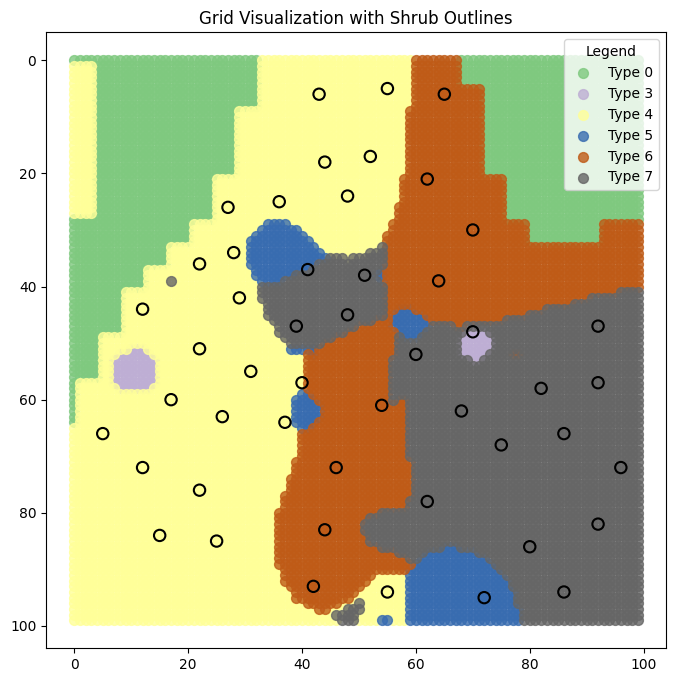

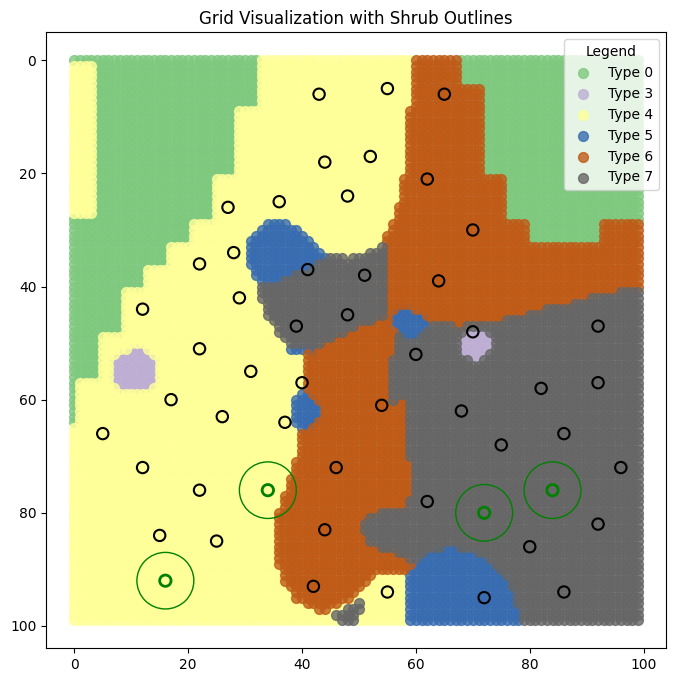

[(76, 34), (76, 84), (80, 72), (92, 16)]


In [38]:
def plant_placement(grid, plant_dict, style="naturalistic", theme=None):
    """
    Combined function that creates the zones and the plants for each zones

    Args:
        grid (np.ndarray): 
        plant_dict: input for plant selection
        stlye: either naturalistic or manicured
        theme: what the areas are either, road or walkway

    Returns:
        np.ndarray: A grid with the randomized types assigned to plantable areas.
    """

    # Generate grid settings
    # Theme comes from the input
    # Style comes from the input
    distribution_seed = None # Seed that is used for random number generation
    number_of_plants = 5 # The max number, in all likelihood,some would not be represented
    percentage_of_seeds = 0.8 # That serve as starting points
    orderliness = 0.4 # The value that determines the weight of the contour line and the randomness function 
    lower_noise = 80
    upper_noise = 100 # These noise controls the amount of variance in the amount of noise that is used in the noise generation
    ditter_amount = 2 # Used to control how much the seeds are moved in naturalistic planting
    visualise_info = False
    
    ##### Generate stuff for the grid information
    # plantable_grid produces a grid that uses a certain value to tell the subsequent function that they should be used in the hatches
    # nearTree_grid produces the area for the shadow of the grid, PLEASE improve this 
    # influence grid, created using topoi map of the contour lines and the random noise
    # shrubs, dictionary of list of plant spots that tells the numbers to the location of seeds
    plantable_grid, nearTree_grid, influence_grids, shrubs, trees = generate_info(grid, style=style, theme=theme, distribution_seed=distribution_seed, number_of_plants=number_of_plants,percentage_of_seeds=percentage_of_seeds, lower_noise= lower_noise, upper_noise= upper_noise, orderliness=orderliness, ditter_amount=ditter_amount, visualise= visualise_info) # Based on the produce_data

    ##### Produce the hatched grid with the seeds for each location based on the data in generate hatches
    # hatched_grid, the grid with the regions
    # same as shrub, a dictionary of list of locations, that has been relabelled
    threshold = 0.05 # minimum distance between the two most likely probabilities before having it become up to probability, anything smaller results in one dominating
    min_size = 100
    shade_influence = 0.10
    shaded_dict = {plant_type: (plant_type % 2 == 0) for plant_type in range(3, 3 + number_of_plants)} #The dictionary of plants that belong in the shaded area

    hatched_grid, seeds = generate_hatches(shaded_dict, style=style, theme=theme, number_of_plants=number_of_plants, plantable_grid=plantable_grid, nearTree_grid=nearTree_grid, influence_grids=influence_grids, shrubs=shrubs, threshold=threshold, min_size=min_size, shade_influence=shade_influence)



    ##### Generate the plant placement using a RL model
    # fetching the data to create the input for the RL model
    # Compress the data to the RL model
    # Use the RL


    # select_plants(hatched_grid,seeds, plant_dict)

    return hatched_grid, seeds, trees

##### Create Grid funciton
# To be replaced/ moved out of the function due to reciving from xuan's function 
model = "./models/23rd.zip" # Model used for the grid Generation
grid = createGrid(model_path=model, seed=None)

generation, seeds, trees = plant_placement(grid, None, style="naturalistic")

visualize_grid_with_outlines(generation, seeds,trees)
print(trees)

## Things that you should not run on a day to day basis

---

### Function to train new model in case something goes wrongs or zips are lost

IDK why but sending zips of models dun work so if u need to use it, just train below and save the model

YOU DO NOT NEED to run it on a day to day basis!

Loaded model from ./models/23rd.zip
Episode finished after 560 steps
Trees placed at: [(76, 94)]
Shrubs placed at: [(6, 66), (6, 88), (12, 56), (14, 72), (14, 94), (20, 62), (24, 88), (28, 56), (30, 80), (32, 66), (32, 94), (38, 58), (38, 74), (38, 86), (46, 66), (52, 88), (60, 82), (60, 94), (64, 68), (68, 88), (70, 78), (76, 68), (78, 84), (80, 8), (86, 90), (88, 64), (92, 82)]


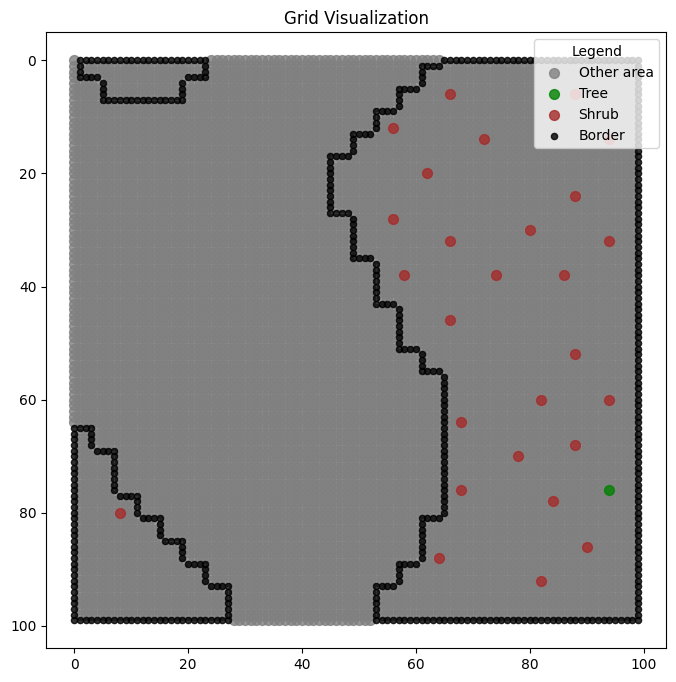

In [ ]:
class customSpatialEnv(gym.Env):
    def __init__(self, octave:float, grid_size:tuple=(100, 100)):
        """
        Args:
            octave (float): octave value from range [1-2] for perlin noise
            grid_size (tuple): (w, h) of grid, defaults to (100, 100)
        """
        super(customSpatialEnv, self).__init__()

        # Create 100x100 grid
        self.grid_size = grid_size
        self.octave = octave
        self.max_attempts = 100000  # Maximum number of attempts
        self.attempt_counter = 0  # Tracks the number of attempts

        self.grid, self.planting_coordinates, self.distances = self._create_environment()

        # Plants: 1 for Tree, 2 for Shrub, 0 for No plant (added)
        self.plants = np.array([0, 1, 2])  # [No Plant, Tree, Shrub]

        # Action space: Use Box for percentage (horizontal, vertical) and plant type (no object, shrub, tree)
        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(3,), dtype=np.float32)

        # Observation space: Dict containing the grid and distances (both horizontal and vertical)
        self.observation_space = spaces.Dict({
            "horizontal_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Horizontal distance (left)
            "vertical_distance": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Vertical distance (top)
            "tree_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of trees
            "shrub_proportion": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),  # Proportion of shrubs
            "good_tree_spot": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32),    # Whether the spot is good for planting a tree
            "border_score": spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  
        })

        self.num_trees = 0
        self.num_shrubs = 0
        self.planted_tree_positions = []

    def reset(self, seed=None, options=None):
        """
        Reset the environment to its initial state.
        """
        super().reset(seed=seed)  # Ensure that we call the parent class reset for seeding

        # Recreate the environment (reinitialize grid, planting coordinates, and distances)
        self.grid, self.planting_coordinates, self.distances = self._create_environment()
        self.attempt_counter = 0

        # Start with the first planting coordinate if available, otherwise default to [0, 0] for distances
        if len(self.distances) > 0:
            initial_distances = self.distances[0]
        else:
            initial_distances = [0, 0]  # Handle case where no distances are available

        horizontal_distance, vertical_distance = initial_distances[1], initial_distances[0]

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)

        tree_proportion = np.array([0.0], dtype=np.float32)
        shrub_proportion = np.array([0.0], dtype=np.float32)
        good_tree_spot = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)
        border_score = np.array([0.0], dtype=np.float32)  # Initial boolean flag (False)

        # Initial observation
        return {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }, {}

    def step(self, action):
        """
        The step function takes a single action, which contains three parts:
        - action[0]: horizontal ratio (0-1).
        - action[1]: vertical ratio (0-1).
        - action[2]: plant type selector (0-1), now including No Plant.
        """

        self.attempt_counter += 1

        # Default value for reward (in case of termination due to exceeding max attempts)
        reward = 0  

        # If the number of attempts exceeds max_attempts, terminate the episode with a penalty
        if self.attempt_counter > self.max_attempts:
            reward = -50  # Apply a significant penalty for exceeding maximum attempts
            terminated = True
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, False, {}

        # Unpack the action
        horizontal_ratio = action[0]
        vertical_ratio = action[1]
        plant_type_selector = action[2]

        # Use the horizontal and vertical ratio to find the nearest planting coordinates
        horizontal_target = horizontal_ratio * self.grid_size[1]  # Scale to grid width
        vertical_target = vertical_ratio * self.grid_size[0]  # Scale to grid height

        # Find the closest coordinate to the generated ratio
        coord_index = np.argmin(np.sum(np.abs(self.planting_coordinates - [vertical_target, horizontal_target]), axis=1))

        # Calculate the difference between the target and the selected plantable coordinates
        selected_coord = self.planting_coordinates[coord_index]
        diff = np.linalg.norm(np.array([vertical_target, horizontal_target]) - np.array(selected_coord))

        # Penalize if the distance is greater than 0.5
        if diff > 20:
            reward = 0  # Apply a penalty for selecting a coordinate that is too far from any plantable spot
            terminated = False
            truncated = False
            return {
                "horizontal_distance": np.array([0.0], dtype=np.float32),
                "vertical_distance": np.array([0.0], dtype=np.float32),
                "tree_proportion": np.array([0.0], dtype=np.float32),
                "shrub_proportion": np.array([0.0], dtype=np.float32),
                "good_tree_spot": np.array([0.0], dtype=np.float32),
                "border_score": np.array([0.0], dtype=np.float32)
            }, reward, terminated, truncated, {}

        # Use the plant type selector to determine the plant type
        if plant_type_selector < 0.33:
            plant_type = 0  # No Plant (new option)
        elif plant_type_selector < 0.66:
            plant_type = 1  # Tree
        else:
            plant_type = 2  # Shrub

        # The rest of the planting logic if a valid spot is selected
        planting_coord = self.planting_coordinates[coord_index]

        if self.grid[planting_coord[0], planting_coord[1]] == 125:  # Plantable spot
            # Update the grid with the selected plant type (1: Tree, 2: Shrub)
            self.grid[planting_coord[0], planting_coord[1]] = self.plants[plant_type]

            if len(self.distances) > 0:  # Ensure there are distances to access
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            # Remove the planted coordinate from the list to avoid planting again in the same spot
            self.planting_coordinates = np.delete(self.planting_coordinates, coord_index, axis=0)
            self.distances = np.delete(self.distances, coord_index, axis=0)

            ####################################################################################
            ### Shrub Proportion and Tree proportion and reward mechanism
            #  Calculate tree and shrub proportions
            total_plants = self.num_trees + self.num_shrubs
            tree_proportion = self.num_trees / total_plants if total_plants > 0 else 0
            shrub_proportion = self.num_shrubs / total_plants if total_plants > 0 else 0
            balance_reward = 0

            # Update tree and shrub counts
            if self.plants[plant_type] == 1:
                self.num_trees += 1
                self.planted_tree_positions.append(planting_coord)  # Track tree positions
                if tree_proportion > 0.2:
                    balance_reward += 2

            elif self.plants[plant_type] == 2:
                self.num_shrubs += 1
                if shrub_proportion > 0.6:
                    balance_reward += 1

            ####################################################################################
            ### Good Tree Spot and Distance mechanism
            good_tree_spot = 1.0  # Assume the spot is good initially
            if plant_type == 1:  # Only check for trees
                for tree_pos in self.planted_tree_positions:
                    if np.array_equal(tree_pos, planting_coord):
                        continue
                    # Calculate the distance between the planted tree and all other trees
                    dist = np.linalg.norm(np.array(planting_coord) - np.array(tree_pos))
                    if dist < 50:  # If any tree is within 50 units, it's not a good spot
                        good_tree_spot = 0.0
                        break
            distance_reward = 0.5
            # Only apply reward for trees (plant_type == 1)
            if self.plants[plant_type] == 1:
                # Apply a reward based on how far the nearest tree is, capped at 50 units
                if good_tree_spot == 1.0:
                    distance_reward = 1  # Normalize reward (closer to 50 = higher reward)
                else:
                    distance_reward = 0

            ####################################################################################

            ### Border Score Segment

            # Retrieve the distances for the selected planting coordinate
            if len(self.distances) > 0:
                horizontal_distance, vertical_distance = self.distances[min(coord_index, len(self.distances) - 1)]
            else:
                horizontal_distance, vertical_distance = 0.0, 0.0

            border_score = 0
            if (abs(horizontal_distance - 0.5) + abs(vertical_distance - 0.5)) > 0.8:
                border_score = 1

            ####################################################################################

            ### Total reward Segment
            reward = 3 * balance_reward + 2 *distance_reward + border_score
            ####################################################################################

            if plant_type == 0:
            # No planting is done, but a small positive reward could be given to avoid excessive no-action use
                reward = 1

        else:
            # Penalize for trying to plant on a non-plantable spot
            reward = -1
            horizontal_distance, vertical_distance = 0.0, 0.0  # Set to zero if invalid action
            tree_proportion = self.num_trees / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            shrub_proportion = self.num_shrubs / (self.num_trees + self.num_shrubs) if (self.num_trees + self.num_shrubs) > 0 else 0
            good_tree_spot = 0.0

        # Ensure the distances are of type float32
        horizontal_distance = np.array([horizontal_distance], dtype=np.float32)
        vertical_distance = np.array([vertical_distance], dtype=np.float32)
        tree_proportion = np.array([tree_proportion], dtype=np.float32)
        shrub_proportion = np.array([shrub_proportion], dtype=np.float32)
        good_tree_spot = np.array([good_tree_spot], dtype=np.float32)
        border_score = np.array([border_score], dtype=np.float32)

        # Observation: the current state of the environment (grid, distances, and tree/shrub proportions)
        observation = {
            "horizontal_distance": horizontal_distance,
            "vertical_distance": vertical_distance,
            "tree_proportion": tree_proportion,
            "shrub_proportion": shrub_proportion,
            "good_tree_spot": good_tree_spot,
            "border_score": border_score
        }

        # Check if the episode should end (plant all possible spots)
        terminated = len(self.planting_coordinates) == 0

        # Truncated remains False
        truncated = False

        info = {
            'diff': diff  # Add diff to the info dictionary
        }

        return observation, reward, terminated, truncated, info


    def _create_environment(self):
        """
        Function to create a test environment
        Runs perlin noise, dithers
        Ensure that at least 7.5% is plantable
        Filters to ensure minimum 10 grid between all coordinates

        Returns:
            planting_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            planting_coord (np.ndarray): (1, num_planting_coord) numpy array
        """ 
        while True:
            noise = PerlinNoise(octaves=self.octave, seed = random.randint(0, 50))
            width, height = self.grid_size

            # Create environment and dither
            perlin_env = np.array([[noise([i/height, j/width]) for j in range(width)] for i in range(height)])
            dithered_perlin_env = self._dither_environment(perlin_env)

            # Check density, more than 7.5% must be plantable
            planting_positions = np.argwhere(dithered_perlin_env == 1)
            planting_density = len(planting_positions) / len(dithered_perlin_env.flatten())

            # If planting density too low, recreate environment with a random grid
            if planting_density > 7.5/100:
                break

        planting_grid, planting_coords  = self._filter_environment(planting_positions)
        boundary = self._draw_and_return_boundary_only(dithered_perlin_env) #just remember to change the input accordingly
        distances, final_grid = self._create_distance_list_grid(planting_grid, boundary, planting_coords)

        return final_grid, planting_coords, distances

    def _dither_environment(self, perlin_env:np.ndarray):
        """
        Function to dither perlin environment using bayer matrix
        
        Args:
            perlin_env (np.ndarray): self.grid_size numpy array with random noise from perlin

        Returns:
            dithered_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
        """
        # 4x4 Normalised Bayer matrix
        bayer_matrix = np.array([
            [0, 8, 2, 10],
            [12, 4, 14, 6],
            [3, 11, 1, 9],
            [15, 7, 13, 5]
        ]) / 16.0  # Normalisation

        # Dither with Bayer Matrix
        bayer_tile_size = bayer_matrix.shape[0]  # Size of the Bayer matrix (4x4)
        dithered_grid = np.zeros_like(perlin_env)
        width, height = self.grid_size

        # Apply Bayer matrix
        for y in range(height):
            for x in range(width):
                bayer_value = bayer_matrix[y % bayer_tile_size, x % bayer_tile_size]
                dithered_grid[y, x] = 1 if perlin_env[y, x] > bayer_value else 0
        
        return dithered_grid

    def _filter_environment(self, planting_positions:np.ndarray):
        """
        Function to remove close coordinates, ensuring all coordinates are at least 10 apart
        All coordinates within 5 grid of the environment borders are also remove as a buffer effect
        
        Args:
            planting_positions (np.ndarray): numpy array of all plantable coordinates from dithering algorithm

        Returns:
            final_grid (np.ndarray): self.grid_size grid of 0 for unplantable and 1 for plantable
            final_planting_coordinates (np.ndarray): (1, num_planting_coord) numpy array        
        """
        min_distance = 10
        filtered_planting_positions = planting_positions.copy()
        
        # Calculate elucidean distance between coordinates
        distances = cdist(filtered_planting_positions, filtered_planting_positions)

        # Keep a numpy array of all filtered position and assume is true
        keep_array = np.ones(len(filtered_planting_positions), dtype=bool)

        # Check for points that are too close
        for i in range(len(filtered_planting_positions)):
            plant_coordinate = filtered_planting_positions[i]
            # Boundary of 5 pixel to prevent tress on the edge
            if plant_coordinate[0] <= 5 or plant_coordinate[0] >= (self.grid_size[0] -5):
                keep_array[i] = False
            
            if plant_coordinate[1] <= 5 or plant_coordinate[1] >= (self.grid_size[1] -5):
                keep_array[i] = False

            # Only consider points that haven't been removed
            if keep_array[i]:  
                for j in range(i + 1, len(filtered_planting_positions)):
                    if distances[i, j] < min_distance:
                        # Remove the second point if it's too close
                        keep_array[j] = False


        final_planting_coordinates = filtered_planting_positions[keep_array]
        # Final grid (All 0s)
        final_grid = np.zeros(self.grid_size)
        # Update grid with planting position
        for coordinates in final_planting_coordinates:
            final_grid[coordinates[0], coordinates[1]] = 1
        return final_grid, final_planting_coordinates

    def _draw_and_return_boundary_only(self, input_grid, threshold_value=128, contour_value=255, dilation_iterations=3):
        '''
        Draws a precise boundary around all yellow regions in the unfiltered grid and returns an array with only the boundary values.
        
        Parameters:
        - threshold_value: int -- the threshold value to segment the yellow area (default: 128).
        - contour_value: int -- the value to set for the boundary pixels in the array (default: 255 for white).
        - dilation_iterations: int -- number of iterations for dilating the image to smooth out the areas (default: 3).
        
        Returns:
        - boundary_array: np.array -- the NumPy array containing only the boundary values.
        '''
        
        # Access the unfiltered grid from the environment
        unfiltered_grid = input_grid
        # Normalize the array to the range 0-255 (assuming it's a float array in range 0-1)
        normalized_image = (unfiltered_grid * 255).astype(np.uint8)

        # Apply a threshold to isolate the yellow area
        _, thresh = cv2.threshold(normalized_image, threshold_value, 255, cv2.THRESH_BINARY)

        # Optionally dilate the thresholded image to fill in gaps in the contours
        if dilation_iterations > 0:
            kernel = np.ones((3, 3), np.uint8)
            thresh = cv2.dilate(thresh, kernel, iterations=dilation_iterations)

        # Find contours on the thresholded image (we only want external contours)
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create an empty array (same shape as normalized_image) to store only the boundary
        boundary_array = np.zeros_like(normalized_image)

        # Draw the contours on the boundary array (without the original regions, only the contours)
        cv2.drawContours(boundary_array, contours, -1, contour_value, thickness=1)

        # Optionally show the boundary array for visualization (you can remove this for efficiency in the environment)
        # plt.imshow(boundary_array, cmap='gray')
        # plt.show()

        # Return the boundary array for further use within the environment
        return boundary_array
    
    def _set_array_borders(self, arr, border_thickness = 5, value = 0):
        '''
        Sets the borders of the class's array to a specified value.
        
        Parameters:
        - border_thickness: int -- the thickness of the border to modify.
        - value: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''
        
        # Assuming the class has a grid or unfiltered grid attribute, modify the array in place.

        # Set top and bottom borders
        arr[:border_thickness, :] = value  # Top border
        arr[-border_thickness:, :] = value  # Bottom border
        
        # Set left and right borders
        arr[:, :border_thickness] = value  # Left border
        arr[:, -border_thickness:] = value  # Right border
        
        # You can also return the modified grid if necessary
        return arr
    
    def _create_distance_list_grid(self, grid, boundary, coordinates):
        '''
        Create the list of distances of each node from the bouyndary values
        
        Parameters:
        - grid: int -- the thickness of the border to modify.
        - boundary: int or float -- the value to set for the borders.
        
        Modifies:
        - self.grid or any other attribute that stores the grid.
        '''

        directions = [
            (-1, 0),  #U
            (1, 0),  #D
            (0, -1), #L
            (0, 1)   #R
        ]

        distances = []
        testing_copy = np.copy(boundary)

        
        for coords in coordinates:
            if grid[coords[0], coords[1]] != 1:
                print("Not Seed position")
                continue

            starting_x, starting_y = coords[1], coords[0]
            testing_copy[coords[0], coords[1]] = 125

            temp_distances = []
            for x, y in directions:
                step = 0
                current_x, current_y = starting_x, starting_y
                while 0 <= current_x < self.grid_size[0] and 0 <= current_y < self.grid_size[1]:
                    step += 1
                    current_x += x
                    current_y += y
                    if boundary[current_x, current_y] == 255:
                        temp_distances.append(step)
                        break
                    if current_x == 0 or current_x == 99 or current_y == 0 or current_y == 99:
                        temp_distances.append(step)
                        break

            horizontal_distance_L = temp_distances[2]/(temp_distances[2] + temp_distances[3])
            horizontal_distance_R = temp_distances[3]/(temp_distances[2] + temp_distances[3])

            vertical_distance_D = temp_distances[1]/(temp_distances[0] + temp_distances[1])
            vertical_distance_U = temp_distances[0]/(temp_distances[0] + temp_distances[1])
            distances.append([vertical_distance_U, horizontal_distance_L])
        return distances, testing_copy

    
    
import matplotlib.patches as mpatches
    
def load_model(env):
    global model
    model = PPO("MultiInputPolicy", env, verbose=1, n_steps=2048, gamma=0.99, learning_rate=0.0003, ent_coef=0.05)
    return model

# Train the model without saving automatically
def train_model(env):
    global model
    model.learn(total_timesteps=100000)
    return model

# Function to render one episode and test the model
def render_episode(env, model):
    obs, _ = env.reset()
    step = 0
    while True:
        action, _states = model.predict(obs, deterministic=False)
        action, _states = model.predict(obs, deterministic=False)

        # Add some noise to the action to encourage exploration
        noise = np.random.normal(0, 0.1, size=action.shape)  # Adjust noise level as needed
        action += noise
        action = np.clip(action, 0, 1)
        obs, reward, terminated, truncated, info = env.step(action)
        step += 1
        diff = info.get('diff', None)  # Get the diff from the info dictionary
        # print(f"Step {step}: Reward = {reward}, Action = {action}, Diff = {diff}")

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return model

def load_pretrained_model(model_path):
    """
    Load a pretrained PPO model from a specified path.
    """
    if not os.path.exists(model_path):
        raise ValueError(f"Model path {model_path} does not exist.")
    
    model = PPO.load(model_path)
    print(f"Loaded model from {model_path}")
    return model


def generate_new_placement(env, model):
    """
    Generate a new grid and use the model to place trees, shrubs, or no plant until all plantable spots are used.
    """
    obs, _ = env.reset()
    step = 0

    while True:
        action, _states = model.predict(obs, deterministic=False)
        noise = np.random.normal(0, 0.05, size=action.shape)
        randomized_action = np.clip(action + noise, 0, 1)
        obs, reward, terminated, truncated, info = env.step(randomized_action)
        
        step += 1

        if terminated or truncated:
            print(f"Episode finished after {step} steps")
            break

    return env.grid  # Only return the grid


def extract_tree_shrub_placements(grid):
    """
    Extracts the tree and shrub placements from the final grid.
    
    Args:
        grid (np.ndarray): The final grid after placement.
    
    Returns:
        trees (list of tuple): List of coordinates of tree placements.
        shrubs (list of tuple): List of coordinates of shrub placements.
    """
    trees = list(zip(*np.where(grid == 1)))
    shrubs = list(zip(*np.where(grid == 2)))
    return trees, shrubs


# Main function to load model and generate new placement
def createGrid(model_path):
    env = customSpatialEnv(octave=1.5, grid_size=(100, 100))
    model = load_pretrained_model(model_path)
    final_grid = generate_new_placement(env, model)
    return final_grid


# Visualization (optional, for debugging)
def visualize_grid_with_circles(grid):
    plt.figure(figsize=(8, 8))
    marker_styles = {
        0: {'color': 'gray', 'label': 'Other area', 'size': 50},
        125: {'color': 'yellow', 'label': 'Plantable', 'size': 50},
        1: {'color': 'green', 'label': 'Tree', 'size': 50},
        2: {'color': 'brown', 'label': 'Shrub', 'size': 50},
        3: {'color': 'blue', 'label': 'No Plant', 'size': 50},
        255: {'color': 'black', 'label': 'Border', 'size': 20},
    }

    for value, style in marker_styles.items():
        indices = np.argwhere(grid == value)
        if len(indices) > 0:
            plt.scatter(indices[:, 1], indices[:, 0], color=style['color'], label=style['label'], s=style['size'], alpha=0.8)

    plt.gca().invert_yaxis()
    plt.legend(title="Legend", loc='upper right')
    plt.title("Grid Visualization")
    plt.grid(False)
    plt.show()


if __name__ == "__main__":
    # Specify the path to the pretrained model directory
    model_path = "./models/23rd.zip"
    final_grid = createGrid(model_path)
    trees, shrubs = extract_tree_shrub_placements(final_grid)
    print("Trees placed at:", trees)
    print("Shrubs placed at:", shrubs)

    # Optional visualization
    visualize_grid_with_circles(final_grid)


## Experimenting time

Compression code:
The code will take the dictionary of the plants and then compress them to four matrix

Shade according to the type
Depth, accounts for hazard and flora